# World Cuisine
### Author: Yunkun Xie
Of all the differences among countries/regions in the world, the diversity of food is definitely the one we appreciate. The motivation behind this proposal is to explore the similarities/differences among a wide variety of beloved cuisines from around the globe. It is by no means an easy task due to the complicated process involved in preparing and cooking. In this project, the cooking process is ignored and my focus will be mostly on the ingredients. The goal is to build a model that characterizes the 'flavor' of food from a specific region/country. To achieve this goal, the following steps will be conducted:

* Obtaining data (web scraping, API)
* Process raw text data (simple parsing, NLP model)
* Modeling (PCA/k-means clustering for unlabeled data, or supervised model for labelled data)
* Model verification

To show the feasibility of the project, I have created the python script to scrape around 5000 recipes from [Allrecipe](http://www.allrecipe.com) from different regions/countries across Asia, Europe and America. The following fields are collected from my script:
* region 
* name
* rating               - - - - - average allrecipe.com user rating (from 0 to 5)
* tried count          - - - - - how many people have tried the recipe
* review count         - - - - - how many people have reviewed the recipe
* cook time            - - - - - the total time of cooking
* calorie 
* serving              - - - - - how many people can this recipe serve
* ingredients

while other fields are important in assessing other subjective factors (such as cooking time vs. recipe popularity), the most informative and relevent column is the 'ingredients' column. It is a complicated column consisting of raw text that loosely follow a pattern. Extract information from this column is the most challenging part of this project. For starters, I have created a simple parsing script that extracts the amount information for any specific ingradient (such as salt(uncountable), milk, onion(countable) and etc). 

Due to time constraints and other factors (such as webpage crash due to frequent inquiries) in collecting the data from scraping the web, the current data size is not very big but still serves as a good start. The following notebook demonstrate the data collection -> pre-processing -> preliminary analysis pipeline.

## Collecting recipes from Allrecipe.com based on different regions/countries
```
user@XXX:dir $ python recipe_scraper.py
```
All recipes will be saved to a .csv file. File name and region/country choice need to be specified inside the script.

In [1]:
%pylab inline
import pandas as pd

from parse_ingredients import simple_ingr_parser   # simple functin to parse the ingredients column
vparser = np.vectorize(simple_ingr_parser)

Populating the interactive namespace from numpy and matplotlib


In [2]:
raw_data = pd.read_csv('./recipes.csv')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4848 entries, 0 to 4847
Data columns (total 9 columns):
region          4848 non-null object
name            4848 non-null object
rating          4848 non-null float64
tried count     4848 non-null int64
review count    4848 non-null int64
cook time       4538 non-null float64
calorie         4807 non-null float64
serving         4848 non-null int64
ingredients     4848 non-null object
dtypes: float64(3), int64(3), object(3)
memory usage: 341.0+ KB


In [3]:
# parse ingredients column

raw_data['milk'] = vparser(raw_data['ingredients'], 'milk') / raw_data['serving']
raw_data = raw_data[raw_data.milk >= 0]

raw_data['vinegar'] = vparser(raw_data['ingredients'], 'vinegar') / raw_data['serving']
raw_data = raw_data[raw_data.vinegar >= 0]

raw_data['garlic'] = vparser(raw_data['ingredients'], 'garlic', countable=True) / raw_data['serving']
raw_data = raw_data[raw_data['garlic'] >= 0]

raw_data['pepper'] = vparser(raw_data['ingredients'], 'pepper', countable=False) / raw_data['serving']
raw_data = raw_data[raw_data['pepper'] >= 0]


# of Japanese recipes: 210
# of Italian recipes: 221


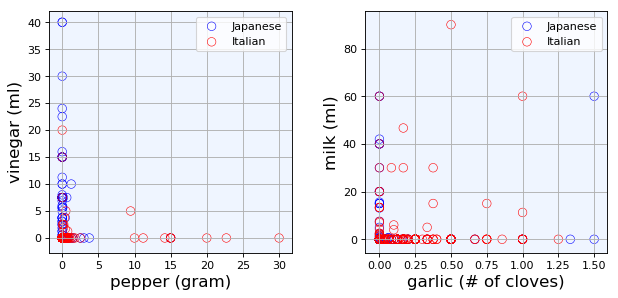

In [4]:
jap = raw_data[raw_data.region == 'Japanese']
print("# of Japanese recipes:", len(jap))
ita = raw_data[raw_data.region == 'Italian']
print("# of Italian recipes:", len(ita))

fig = figure(figsize=(9, 4), dpi=80, facecolor='w', edgecolor='k')

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(jap['pepper'].values, jap['vinegar'].values, label='Japanese',
            s=60, linewidth=0.5, facecolors='none', edgecolors='b')
ax1.scatter(ita['pepper'].values, ita['vinegar'].values, label='Italian',
            s=60, linewidth=0.5, facecolors='none', edgecolors='r')
ax1.set_xlabel('pepper (gram)', fontsize=15)
ax1.set_ylabel('vinegar (ml)', fontsize=15)
ax1.legend()
ax1.set_facecolor('#eff5ff')
ax1.grid(True)

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(jap['garlic'].values, jap['milk'].values, label='Japanese',
            s=60, linewidth=0.5, facecolors='none', edgecolors='b')
ax2.scatter(ita['garlic'].values, ita['milk'].values, label='Italian',
            s=60, linewidth=0.5, facecolors='none', edgecolors='r')
ax2.set_xlabel('garlic (# of cloves)', fontsize=15)
ax2.set_ylabel('milk (ml)', fontsize=15)
ax2.set_facecolor('#eff5ff')
ax2.legend()
ax2.grid(True)

fig.subplots_adjust(wspace=.3)

The two figures shown above illustrate how cuisine from different regions have different flavors from different usage of some common ingredients. In principle, this plot should be high dimensional due to large number of possible cooking ingredients. I avoided some most common ingredients (such as salt or sugar which don't really add any 'flavor') and some region specific ingredients (such as soy sauce, which is widely used in Asian; or cheese, which is widely used in western cuisine). Although not shown here, these obvious region-specific ingredients can be the key features in separating recipes from different regions in a model. As an example shown here, Japanese food tend to use vinegar more (both in quantity and # of dishes) than italian food while pepper is not widely used in Japanese cuisine. The second figure shows that Japanese food don't usually use milk and garlic together but Italian food do.